## Red Convolutiva para Deteccion de Animales
### Descripción
En este proyecto lo que haremos será entrenar una red convolutiva para poder decidir que animales tenemos en cada foto, entonces extraeremos caracteristicas de imagaenes de animales. Para ello, utilizaremos un dataset de imágenes de animales que contiene 7 clases diferentes. La red que usaremos la crearemos con la librería Pytorch.

### Dataset
Utilizaremos el dataset de Kaggle llamado "Animal Image Dataset (90 Different Animals)
" que contiene 5400 imagenes de 90 clases diferentes de animales. El dataset se encuentra en el siguiente enlace: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

Para que sea más sencillo para el proyecto, se ha decidido reducir el número de clases a 7, las cuales son las siguientes:
- Swan (Cisne)
- Tiger (Tigre)
- Turkey (Pavo)
- Wolf (Lobo)
- Wombat (Wombat)
- Zebra (Cebra)
- Woodpecker (Pájaro Carpintero)

### Código
Primero, importaremos las librerías necesarias para el proyecto.

#### Librerías
Las librerías que utilizaremos son las siguientes:
- torch: Librería de Pytorch que nos permitirá crear la red convolutiva.
- torchvision: Librería de Pytorch que nos permitirá cargar el dataset y transformar las imágenes.
- torch.nn: Módulo de Pytorch que nos permitirá crear la red neuronal.
- torch.nn.functional: Módulo de Pytorch que nos permitirá utilizar funciones de activación.
- torch.utils.data: Módulo de Pytorch que nos permitirá trabajar con los datos.
- torch.optim: Módulo de Pytorch que nos permitirá utilizar optimizadores.
- sklearn.metrics: Librería de Scikit-learn que nos permitirá calcular la matriz de confusión.
- matplotlib.pyplot: Librería que nos permitirá graficar la matriz de confusión.
- numpy: Librería que nos permitirá realizar operaciones matemáticas.


In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

#### Carga de Datos
Primero crearemos los transforadores para las imagenes de entrenamiento y de test, a esto se le llamada data augmentation, que es una técnica que nos permite aumentar el tamaño del dataset de entrenamiento, con esto lo que hemos conseguido es que la red neuronal generalice mejor. Luego cargaremos el dataset y crearemos los dataloaders para el entrenamiento y test.

Dividiremos el dataset en 80% para entrenamiento y 20% para test. Donde usando random_split evitamos que haya sesgo en los datos, ya que se dividen de forma aleatoria y no se repiten las imágenes.

En la ultima parte de carga de datos usaremos DataLoader para cargar los datos de entrenamiento y test, usaremos un batch size de 64, que significa que se cargarán 64 imágenes a la vez entre cada iteración.

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar
    transforms.RandomHorizontalFlip(p=0.5),  # Voltear horizontalmente
    transforms.RandomRotation(20),  # Rotar aleatoriamente hasta 20 grados
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Recortar aleatoriamente
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Cambios en color
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar
])

train_dataset = datasets.ImageFolder(root='dataset_animales/animals/animals', transform=train_transform)
test_dataset = datasets.ImageFolder(root='dataset_animales/animals/animals', transform=test_transform)

train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_data, _ = random_split(train_dataset, [train_size, test_size])
_, test_data = random_split(test_dataset, [train_size, test_size])

# Guardar los datos para entrenar y testear
train_data = DataLoader(train_data, batch_size=64, shuffle=True) 
test_data = DataLoader(test_data, batch_size=64, shuffle=False)

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Red Convolucional
Crearemos una red convolutiva con 3 capas convolutivas, 1 MaxPool2d, 1 Dropout y 3 capas lineales. La red tendrá la siguiente estructura:
- Capa convolutiva 1 : 3 canales de entrada, 48 canales de salida, kernel de 3x3, padding de 1 y stride de 1.
- Capa convolutiva 2 : 48 canales de entrada, 128 canales de salida, kernel de 3x3, padding de 1 y stride de 1.
- Capa convolutiva 3 : 128 canales de entrada, 64 canales de salida, kernel de 3x3, padding de 1 y stride de 1.
- MaxPool2d : kernel de 2x2 y stride de 2.
- Dropout : probabilidad de 0.5.
- Capa lineal 1 : 64x28x28 neuronas de entrada y 128 neuronas de salida.
- Capa lineal 2 : 128 neuronas de entrada y 96 neuronas de salida.
- Capa lineal 3 : 96 neuronas de entrada y 7 neuronas de salida.

Como función de activación utilizaremos leaky_relu en las capas convolutivas y ReLU en la segunda capa lineal, en la primera utilizaremos leaky_relu. La diferencia entre ReLU y Leaky ReLU es que esta última introduce una pequeña pendiente para los valores negativos y ayuda a mitigar el problema de neuronas muertas.


In [10]:
import torch.nn as nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Para imágenes de 224x224 -> 128x28x28 después de pooling
        self.fc2 = nn.Linear(128, 96)
        self.fc3 = nn.Linear(96, 7)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Ajustar el tamaño dinámicamente
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Entrenamiento y Test
Para el entrenamiento utilizaremos el optimizador Adam con una tasa de aprendizaje de 0.001 y una función de pérdida de entropía cruzada. Entrenaremos la red durante 30 épocas y calcularemos la precisión en cada época y la perdida en cada iteración.

También tenemos implementado la condición de parada temprana, que nos permitirá detener el entrenamiento si la precisión en el conjunto de validación no mejora en 5 épocas.

In [11]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Parámetros de parada anticipada
patience = 5  # Número de épocas sin mejora antes de detener
min_delta = 0.001  # Mejora mínima requerida
best_loss = float('inf')  # Inicializar con pérdida infinita
patience_counter = 5  # Contador de épocas sin mejora

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listas para guardar loss y accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 30
for epoch in range(epochs):
    # Train
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_data:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Test
    model.eval() 
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_data:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_data)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Mostrar el resultado al final de cada época
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Parada anticipada
    if test_loss < best_loss - min_delta:  # Si mejora la pérdida de validación
        best_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Guardar modelo
    else:
        patience_counter += 1
        print(f"No mejoró. Contador de paciencia: {patience_counter}/{patience}")

    if patience_counter >= patience:  # Si se alcanza el límite de paciencia
        print("Se activó la parada anticipada.")
        break

# Cargar el mejor modelo después de entrenar
model.load_state_dict(torch.load('best_model.pth'))
print("Mejor modelo cargado.")


Epoch 1, Train Loss: 1.9516, Train Accuracy: 16.07%
Epoch 1, Test Loss: 1.9590, Test Accuracy: 20.00%
Epoch 2, Train Loss: 1.8879, Train Accuracy: 22.32%
Epoch 2, Test Loss: 1.8328, Test Accuracy: 24.71%
Epoch 3, Train Loss: 1.8339, Train Accuracy: 27.68%
Epoch 3, Test Loss: 1.7046, Test Accuracy: 28.24%
Epoch 4, Train Loss: 1.6841, Train Accuracy: 33.93%
Epoch 4, Test Loss: 1.5283, Test Accuracy: 43.53%
Epoch 5, Train Loss: 1.6134, Train Accuracy: 36.31%
Epoch 5, Test Loss: 1.5420, Test Accuracy: 34.12%
No mejoró. Contador de paciencia: 1/5
Epoch 6, Train Loss: 1.4645, Train Accuracy: 40.48%
Epoch 6, Test Loss: 1.7554, Test Accuracy: 28.24%
No mejoró. Contador de paciencia: 2/5
Epoch 7, Train Loss: 1.5052, Train Accuracy: 41.37%
Epoch 7, Test Loss: 1.1940, Test Accuracy: 62.35%
Epoch 8, Train Loss: 1.4023, Train Accuracy: 46.73%
Epoch 8, Test Loss: 1.1897, Test Accuracy: 61.18%
Epoch 9, Train Loss: 1.2475, Train Accuracy: 55.65%
Epoch 9, Test Loss: 1.0670, Test Accuracy: 62.35%
Epoch 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18164\4073659307.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


### Gráficas
Al final del entrenamiento y test, graficaremos las gráficas de perdida y precision por epoca, tanto del conjunto de entrenamiento como del conjunto de test. También graficaremos la matriz de confusión para ver como se comporta la red con cada clase.

#### Graficas de Precisión y Pérdida
Primero graficaremos la precisión y la pérdida en cada época, tanto del conjunto de entrenamiento como del conjunto de test.

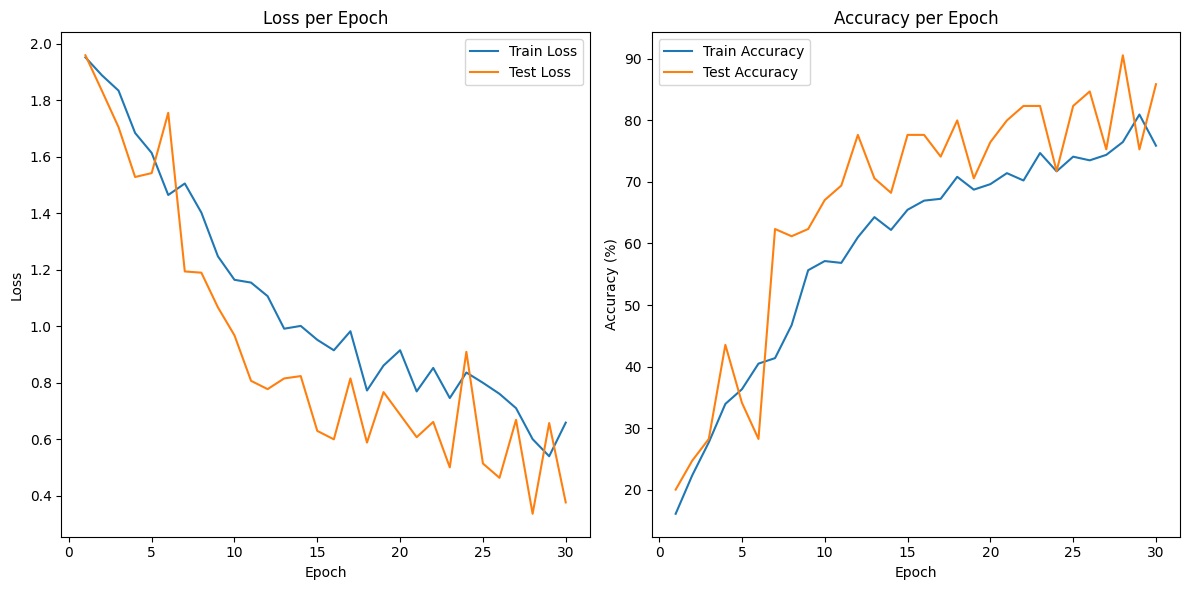

In [12]:
# Graficamos las métricas
epochs_range = range(1, epochs+1)

# Graficar pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

**Resultados**

Como podemos ver en las gráficas, la precisión en el conjunto de entrenamiento aumenta con cada época, mientras que la precisión en el conjunto de test va dando saltos, esto se debe a que la red está generalizando bien y no está sobreajustando.

#### Grafica de Matriz de Confusión
Luego graficaremos la matriz de confusión para ver como se comporta la red con cada clase.

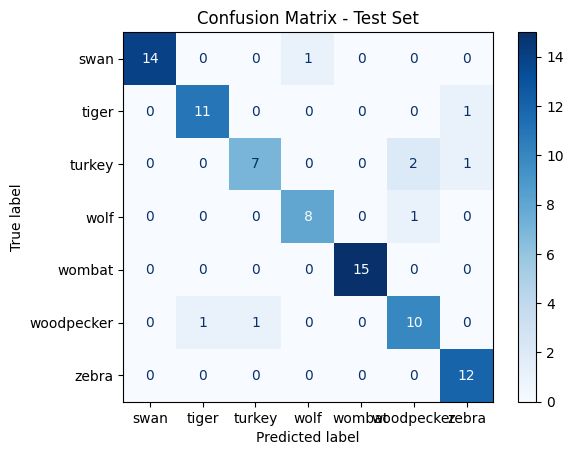

Accuracy of the model on the test images: 90.58823529411765%


In [13]:
# Evaluación final y matriz de confusión
correct = 0
total = 0
all_labels = []
all_predictions = []

model.eval()  # No necesitamos gradientes en la evaluación
with torch.no_grad():
    for images, labels in test_data:  # Usar test_loader
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_predictions)

# Obtener las clases (nombres de los animales)
class_names = test_data.dataset.dataset.classes  # Acceder al dataset original

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Mostrar la precisión final en el conjunto de prueba
print(f'Accuracy of the model on the test images: {100 * correct / total}%')


**Resultados**

Como podemos observar en la matriz de confusión, la red convolutiva ha tenido un buen desempeño en la clasificación de las 7 clases de animales, ya que la mayoría de las clases han sido clasificadas correctamente.